<div class="alert alert-block alert-danger">
<b>
Note:
</b> 
Work in progress!
</div>


<div class="alert alert-block alert-info">
<b>
Note:
</b> 
Following along with the book but condensing and making my own changes.
</div>


In [125]:
import os, tarfile, urllib
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

# Obtain data

In [ ]:
def download_data(housing_url):
    os.makedirs('datasets/housing', exist_ok = True)
    tgz_path = 'datasets/housing/housing.tgz'
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = 'datasets/housing')
    housing_tgz.close()

In [ ]:
housing_url = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz'
download_data(housing_url)

In [12]:
df = pd.read_csv('datasets/housing/housing.csv')

# Data Exploration

### Take a peek

In [26]:
df.shape

(20640, 10)

In [27]:
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [77]:
df.head(5).style.set_properties(**{'background-color': 'yellow'}, subset=['longitude'])

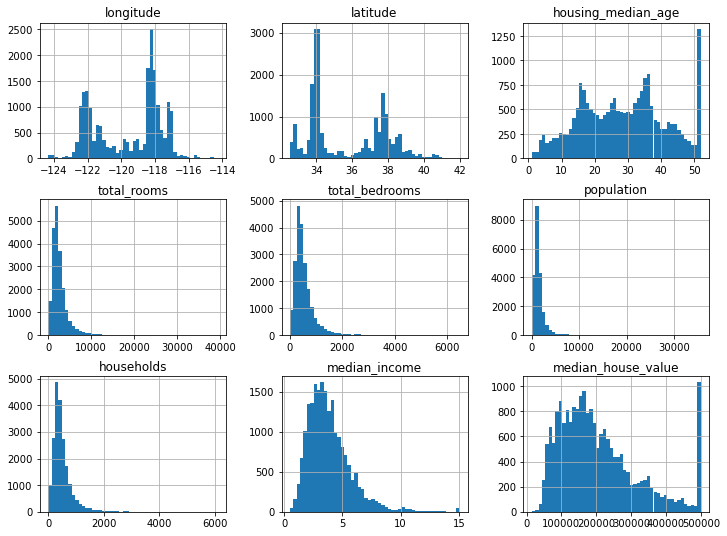

In [65]:
df.hist(bins = 50, figsize = (12,9))
plt.show()

### Create training and test sets

In [67]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [70]:
df['income_cat'] = pd.cut(df['median_income'], bins = [0, 1.5, 3., 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])

<AxesSubplot:>

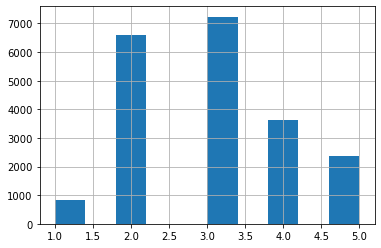

In [71]:
df['income_cat'].hist()

In [73]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_idx, test_idx in split.split(df, df['income_cat']):
    strat_train, strat_test = df.loc[train_idx], df.loc[test_idx]

In [74]:
strat_test['income_cat'].value_counts()/len(strat_test)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [75]:
for _ in (strat_train, strat_test):
    _.drop('income_cat', axis = 1, inplace = True)

### Visualize

In [84]:
df = strat_train.copy()

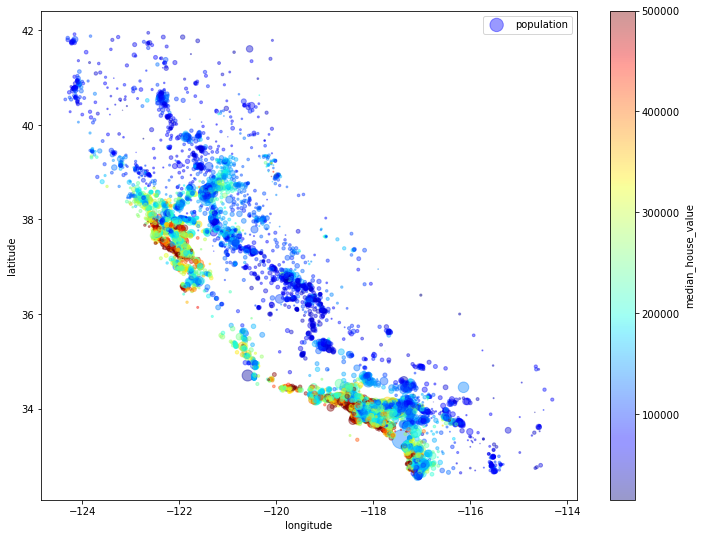

In [95]:
df.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4, 
        s = df['population']/100, label = 'population', figsize = (12,9), 
        c = 'median_house_value', cmap = 'jet', colorbar = True, sharex = False)
plt.legend();

In [56]:
m1 = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=5, control_scale=True)

In [57]:
mc = MarkerCluster()
for idx, row in df.iterrows():
#     folium.Marker([row['latitude'], row['longitude']]).add_to(m1)
    mc.add_child(Marker([row['latitude'], row['longitude']]))
m1.add_child(mc)

### Correlations

In [97]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

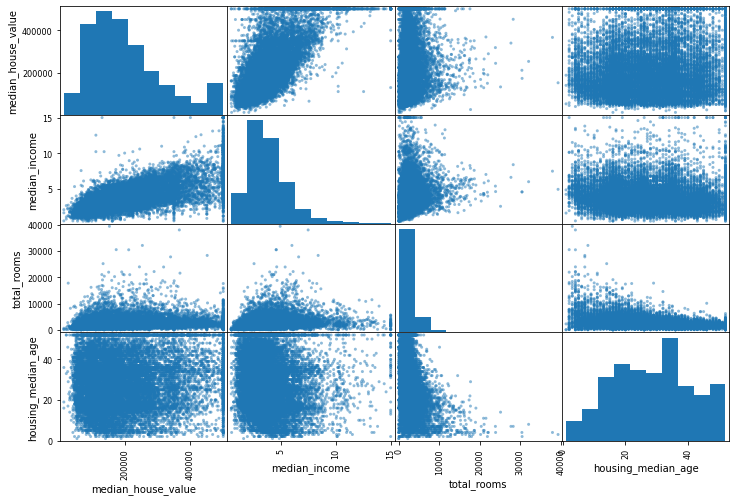

In [104]:
attr = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(df[attr], figsize = (12, 8));

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

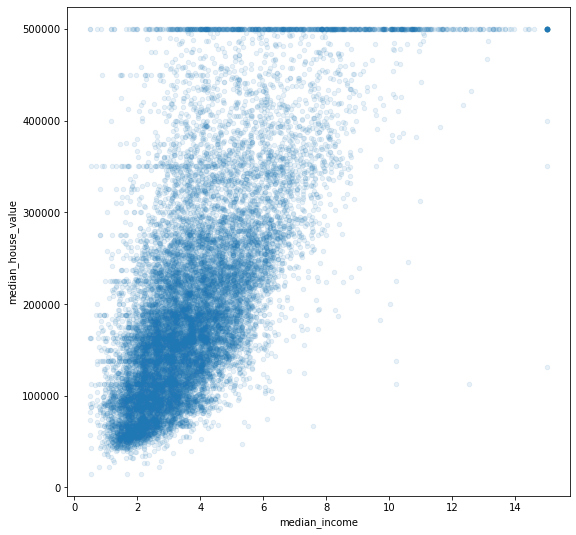

In [107]:
df.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1, figsize = (9,9))

### Feature Engineering

In [108]:
df['rooms_per_household'] = df['total_rooms']/df['households']
df['bedrooms_per_room'] = df['total_bedrooms']/df['total_rooms']
df['population_per_household'] = df['population']/df['households']

In [109]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

# Data preparation

### Data cleaning

In [143]:
df = strat_train.drop('median_house_value', axis = 1)
df_labels = strat_train['median_house_value'].copy()

In [144]:
df.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
ocean_proximity        object
dtype: object

In [145]:
dtypes = {'longitude':'float32', 'latitude':'float32', 'housing_median_age':'uint8', 'total_rooms':'uint16', 
          'total_bedrooms':'uint16', 'population':'uint16', 'households':'uint16', 
          'median_income':'float32', 'ocean_proximity':'category'}

In [146]:
df.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
ocean_proximity       False
dtype: bool

In [148]:
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace = True)

In [149]:
df = df.astype(dtypes)
df_labels = df_labels.astype({'median_house_value':'uint32'})

In [151]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [152]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [153]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(df.values)

In [154]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'median')), 
                         ('attribs_adder', CombinedAttributesAdder()), 
                          ('std_scaler', StandardScaler())])

In [155]:
df_num = df.drop('ocean_proximity', axis = 1)

In [156]:
num_attribs = list(df_num)
cat_attribs = ['ocean_proximity']

In [157]:
full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs), 
                                   ('cat', OneHotEncoder(), cat_attribs),])

In [158]:
df_prepared = full_pipeline.fit_transform(df)

In [159]:
pd.DataFrame(df_prepared).head(2)

0         1         2         3         4         5         6   \
0 -0.94135  1.347438  0.027564  0.584777  0.640371  0.732602  0.556286   
1  1.17178 -1.192440 -1.722018  1.261467  0.781561  0.533612  0.721318   

         7         8         9         10   11   12   13   14   15  
0 -0.893647  0.017395  0.006223 -0.121122  0.0  1.0  0.0  0.0  0.0  
1  1.292168  0.569256 -0.040811 -0.810867  0.0  0.0  0.0  0.0  1.0

<div class="alert alert-block alert-danger">
<b>
TO DO:
</b> 
Change the transformer so that column names survive.
</div>

# Select and train a model

### Training and evaluating on the training set

In [160]:
from sklearn.linear_model import LinearRegression

In [161]:
lin_reg = LinearRegression()
lin_reg.fit(df_prepared, df_labels)

LinearRegression()

In [162]:
some_data = df.iloc[:5]
some_label = df_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

In [163]:
print(f"Predictions: {lin_reg.predict(some_data_prepared)}")

Predictions: [ 86016. 307712. 152064. 187904. 243584.]


In [164]:
print(f"Labels: {list(some_label)}")

Labels: [72100, 279600, 82700, 112500, 238300]


In [165]:
from sklearn.metrics import mean_squared_error

In [166]:
housing_predictions = lin_reg.predict(df_prepared)
lin_mse = mean_squared_error(df_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68635.18169920624

In [167]:
from sklearn.tree import DecisionTreeRegressor

In [168]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(df_prepared, df_labels)

DecisionTreeRegressor()

In [169]:
df_predictions = tree_reg.predict(df_prepared)
tree_mse = mean_squared_error(df_labels, df_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

### Better evaluation using cross-validation

In [170]:
from sklearn.model_selection import cross_val_score

In [173]:
scores = cross_val_score(tree_reg, df_prepared, df_labels, scoring = 'neg_mean_squared_error', cv = 10)
tree_rmse_scores = np.sqrt(-scores)
print(f"Scores: {tree_rmse_scores}")
print(f"Mean: {tree_rmse_scores.mean()}")
print(f"Standard deviation: {tree_rmse_scores.std()}")

Scores: [73563.92133263 70316.09262983 67428.37179916 70013.47974247
 69936.00297653 78211.87484714 72298.66302716 73095.10229453
 68873.76421054 70605.77874997]
Mean: 71434.30516099505
Standard deviation: 2877.159348587467


In [175]:
from sklearn.ensemble import RandomForestRegressor

In [176]:
forest_reg = RandomForestRegressor()
forest_reg.fit(df_prepared, df_labels)

RandomForestRegressor()

In [179]:
df_predictions = forest_reg.predict(df_prepared)
forest_mse = mean_squared_error(df_labels, df_predictions)
forest_rmse = np.sqrt(forest_mse)
print(f"Scores: {tree_rmse_scores}")
print(f"Mean: {tree_rmse_scores.mean()}")
print(f"Standard deviation: {tree_rmse_scores.std()}")

Scores: [73563.92133263 70316.09262983 67428.37179916 70013.47974247
 69936.00297653 78211.87484714 72298.66302716 73095.10229453
 68873.76421054 70605.77874997]
Mean: 71434.30516099505
Standard deviation: 2877.159348587467


<div class="alert alert-block alert-danger">
<b>
TO DO:
</b> 
Try out a couple more models and clean it up into definitions.
</div>

# Fine tune your model

### Grid search

In [181]:
from sklearn.model_selection import GridSearchCV

In [182]:
param_grid = [{'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]}, 
              {'bootstrap':[False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]}]

In [183]:
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, 
                           scoring = 'neg_mean_squared_error', 
                           return_train_score = True)
grid_search.fit(df_prepared, df_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [184]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [185]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [187]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64084.29723206078 {'max_features': 2, 'n_estimators': 3}
55490.72984505781 {'max_features': 2, 'n_estimators': 10}
52627.093959591555 {'max_features': 2, 'n_estimators': 30}
60140.22802826441 {'max_features': 4, 'n_estimators': 3}
53058.97787914048 {'max_features': 4, 'n_estimators': 10}
50229.29728372477 {'max_features': 4, 'n_estimators': 30}
59775.14977086807 {'max_features': 6, 'n_estimators': 3}
52282.21855023089 {'max_features': 6, 'n_estimators': 10}
49985.58063560253 {'max_features': 6, 'n_estimators': 30}
58259.032029641996 {'max_features': 8, 'n_estimators': 3}
52367.624137138715 {'max_features': 8, 'n_estimators': 10}
49961.42399863111 {'max_features': 8, 'n_estimators': 30}
62506.99352811882 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54689.41211422449 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59810.133115129065 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52178.62685299353 {'bootstrap': False, 'max_features': 3, 'n_estimators'

<div class="alert alert-block alert-danger">
<b>
TO DO:
</b> 
Add in some progress tracking?
</div>

### Analyze the best models and their errors

In [188]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.41000791e-02, 6.50002358e-02, 4.25079871e-02, 1.46192747e-02,
       1.47599308e-02, 1.51347162e-02, 1.36264737e-02, 3.36483093e-01,
       5.32151231e-02, 1.10900076e-01, 8.06392890e-02, 5.38882804e-03,
       1.68592192e-01, 5.04298627e-05, 1.87757448e-03, 3.10469691e-03])

In [189]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.3364830933703724, 'median_income'),
 (0.16859219183845683, 'INLAND'),
 (0.11090007604137554, 'pop_per_hhold'),
 (0.08063928895782155, 'bedrooms_per_room'),
 (0.07410007910054836, 'longitude'),
 (0.06500023581393595, 'latitude'),
 (0.053215123090601835, 'rooms_per_hhold'),
 (0.04250798707619821, 'housing_median_age'),
 (0.015134716221640162, 'population'),
 (0.014759930774547965, 'total_bedrooms'),
 (0.014619274674444393, 'total_rooms'),
 (0.013626473744589168, 'households'),
 (0.005388828041357663, '<1H OCEAN'),
 (0.0031046969139784377, 'NEAR OCEAN'),
 (0.0018775744774219094, 'NEAR BAY'),
 (5.042986270959903e-05, 'ISLAND')]

<div class="alert alert-block alert-danger">
<b>
TO DO:
</b> 
Outliers?
</div>

### Evaluate your system on the test set

In [190]:
final_model = grid_search.best_estimator_

In [191]:
x_test = strat_test.drop('median_house_value', axis = 1)
y_test = strat_test['median_house_value'].copy()

In [192]:
x_test_prepared = full_pipeline.transform(x_test)

In [193]:
final_predictions = final_model.predict(x_test_prepared)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))
final_rmse

47499.94453846019

In [194]:
from scipy import stats

In [195]:
confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, 
                         loc = squared_errors.mean(), 
                         scale = stats.sem(squared_errors)))

array([45550.25075705, 49372.70620781])